In [1]:
###libs
import os
import argparse
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2 
###files
from config import Config as cfg
from dataProcessing import VOC_dataset as dataset
from models.network import NetAPI
from trainer import Trainer
from utils import tensor_to_img,cal_tp_per_item


In [2]:
def draw_bboxes(img,bboxes,color,th=1):
    img_ = img.copy()
    for bbox in bboxes:
        x,y,w,h = bbox
        pt1 = (int(x-w/2),int(y-h/2))
        pt2 = (int(x+w/2),int(y+h/2))
        img_ =cv2.rectangle(img_,pt1,pt2,color,thickness = th)
    return img_
def draw_bboxes_wt_text(img,bboxes,color,th=1):
    img_ = img.copy()
    for bbox in bboxes:
        x,y,w,h = bbox
        pt1 = (int(x-w/2),int(y-h/2))
        pt2 = (int(x+w/2),int(y+h/2))
        img_ =cv2.rectangle(img_,pt1,pt2,color,thickness = th)
    return img_

In [3]:
exp = 'visual'
resume = 'best'
net = 'yolo_spp'

In [8]:
config  = cfg(mode='train')
val_set = dataset(config)
val_set = dataset(config,mode='val')
val_bs = 2
val_loader = DataLoader(val_set,batch_size=val_bs,shuffle=False,pin_memory=False,collate_fn=val_set.collate_fn)
datasets = {'val':val_loader}

config.device = torch.device("cuda")
torch.cuda.empty_cache()
#for reproducity
torch.manual_seed(2333)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [9]:
network = NetAPI(config,net,'yolo',init=False)


In [10]:
config.exp_name = exp
det = Trainer(config,datasets,network,(resume,-1))

load:../checkpoints/visual/epoch_best.pt


In [7]:
imgs,pds,gts,sizes = det.validate_random()
print(imgs[0].shape)

0d2e2b65b
0d2e2b65b
torch.Size([3, 512, 512])


In [11]:
imgs,pds1,gts1,sizes = det.validate_random()
print(imgs[0].shape)

0d2e2b65b
a127f3085
torch.Size([3, 512, 512])


torch.Size([68, 5])
tensor([[0.1924, 0.9575, 0.0586, 0.0850],
        [0.0288, 0.9556, 0.0576, 0.0596],
        [0.8687, 0.9380, 0.0811, 0.0381],
        [0.7080, 0.9229, 0.1172, 0.0645],
        [0.8188, 0.9058, 0.1064, 0.0557],
        [0.4326, 0.8882, 0.0684, 0.0850],
        [0.2490, 0.8735, 0.0898, 0.1045],
        [0.1401, 0.8613, 0.0713, 0.0664],
        [0.8955, 0.8521, 0.0840, 0.0674],
        [0.7319, 0.8428, 0.0693, 0.0527],
        [0.9629, 0.8101, 0.0742, 0.0576],
        [0.8838, 0.7764, 0.0703, 0.0801],
        [0.1772, 0.7646, 0.0557, 0.0625],
        [0.2715, 0.7627, 0.0918, 0.0586],
        [0.4482, 0.7222, 0.0664, 0.0596],
        [0.1226, 0.7207, 0.0732, 0.0605],
        [0.6377, 0.7173, 0.0742, 0.0850],
        [0.2461, 0.6973, 0.0625, 0.0645],
        [0.3140, 0.6768, 0.0811, 0.0781],
        [0.1782, 0.6694, 0.0596, 0.0459],
        [0.6880, 0.6421, 0.0537, 0.0518],
        [0.6309, 0.6167, 0.0527, 0.0791],
        [0.7256, 0.5415, 0.0586, 0.0986],
        [0.626

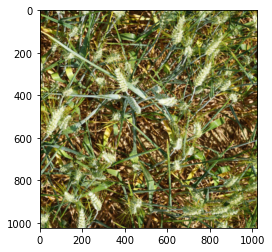

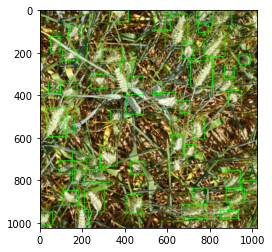

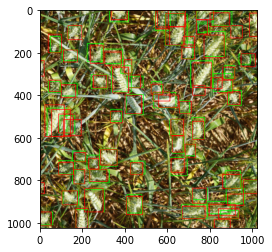

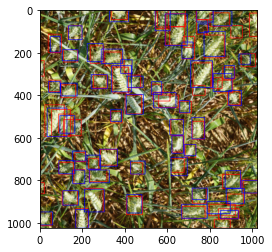

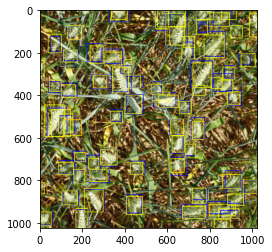

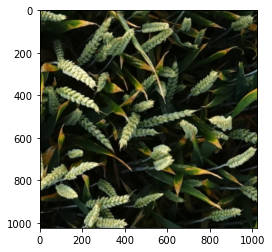

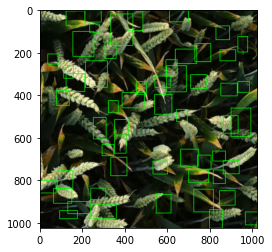

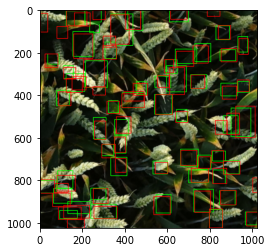

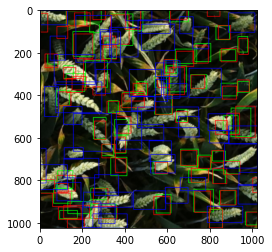

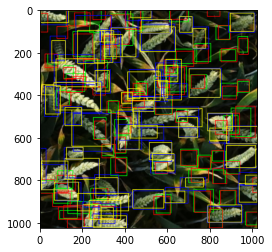

In [12]:
for b in range(val_bs):
    pd = pds[b]
    gt = gts[b]
    h,w = sizes[b]
    img = tensor_to_img(imgs[b])
    tsize = max(h,w)
    diff = (tsize-h,tsize-w)
    pad = (diff[0]//2,diff[1]//2,diff[0]-diff[0]//2,diff[1]-diff[1]//2)
    img = cv2.resize(img,(tsize,tsize))
    img = img[pad[0]:(tsize-pad[2]),pad[1]:(tsize-pad[3])]
    print(pd.shape)
    print(gt)
    plt.figure()
    plt.imshow(img)
    tp,_ = cal_tp_per_item(pd,gt,0.75)
    tp = tp.sum()
    print(tp/gt.shape[0])
    print(tp/pd.shape[0])
    print(tp/(gt.shape[0]+pd.shape[0]))
    img_ = draw_bboxes(img,gt*tsize,(0,1,0),2)
    plt.figure()
    plt.imshow(img_)
    pdbboxes = pd[:,:4]
    img_ = draw_bboxes(img_,pdbboxes,(1,0,0),2)
    plt.figure()
    plt.imshow(img_)
    img_ = draw_bboxes(img_,gts1[b],(0,0,1),2)
    plt.figure()
    plt.imshow(img_)
    img_ = draw_bboxes(img_,pds1[b][:,:4],(1,1,0),2)
    plt.figure()
    plt.imshow(img_)